# **Duplicate Question Pairs**

## Data Preprocessing 

In [2]:
# import nltk

# nltk.download('stopwords')

In [3]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')


In [4]:
# importing dataset

df = pd.read_csv('questions.csv')

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
# selecting randomly 50000 rows

# new_df_1 = df[df['is_duplicate'] == 0].sample(25000, random_state=2)
# new_df_2 = df[df['is_duplicate'] == 1].sample(25000, random_state=2)

# new_df = pd.concat([new_df_1, new_df_2], axis=0)

new_df = df.sample(30000, random_state=2)

new_df = new_df.sample(frac=1).reset_index(drop=True)


In [7]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,290580,62222,411884,Convex lense bend toward principle axis why?,Why does light bend towards normal and not awa...,0
1,303330,426446,426447,How are companies setting up search retargeting?,How do I Get Started with my career in Ethical...,0
2,242532,156101,354753,What is the Maruti Nexa?,Is the launch of the NEXA showroom chain for t...,0
3,100753,86476,77175,How do you potty train a English Bulldog/Pitbu...,How do you potty train a 4 month old puppy?,1
4,64283,111724,111725,What does the; _) mean?,What does this mean?,0


In [8]:
new_df.shape

(30000, 6)

In [9]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            30000 non-null  int64 
 1   qid1          30000 non-null  int64 
 2   qid2          30000 non-null  int64 
 3   question1     30000 non-null  object
 4   question2     30000 non-null  object
 5   is_duplicate  30000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [10]:
# checking null values

new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [11]:
# checking duplicate values

new_df.duplicated().sum()

0

In [12]:
# checking values in target variables

print(new_df['is_duplicate'].value_counts())
(new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100

is_duplicate
0    18863
1    11137
Name: count, dtype: int64


is_duplicate
0    62.876667
1    37.123333
Name: count, dtype: float64

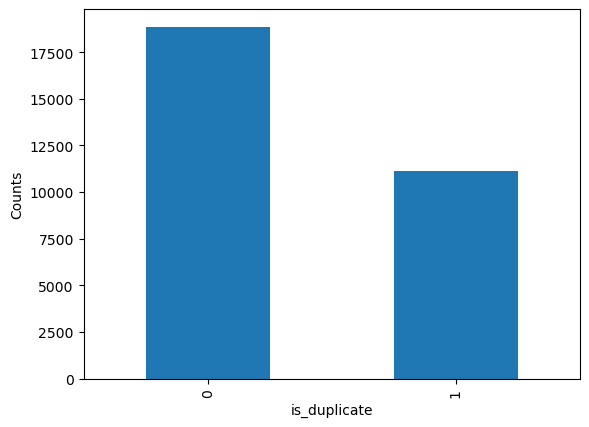

In [13]:
# plotting target values

new_df['is_duplicate'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

In [14]:
# data preprocessing

def preprocess(q):
    
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

     # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

        # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [15]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [16]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,290580,62222,411884,convex lense bend toward principle axis why,why does light bend towards normal and not awa...,0
1,303330,426446,426447,how are companies setting up search retargeting,how do i get started with my career in ethical...,0
2,242532,156101,354753,what is the maruti nexa,is the launch of the nexa showroom chain for t...,0
3,100753,86476,77175,how do you potty train a english bulldog pitbu...,how do you potty train a 4 month old puppy,1
4,64283,111724,111725,what does the _ mean,what does this mean,0


## Feature Engineering

In [17]:
# creating new feature, length of charectors

new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [18]:
# length of questions 

new_df['q1_num_word'] = new_df['question1'].apply(lambda itr: len(itr.split(" ")))
new_df['q2_num_word'] = new_df['question2'].apply(lambda itr: len(itr.split(" ")))

In [19]:
# counting common words in both questions

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [20]:
new_df['common_words'] = new_df.apply(common_words, axis=1)

In [21]:
# counting total words in both questions

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) + len(w2)

In [22]:
new_df['total_words'] = new_df.apply(total_words, axis=1)

In [23]:
# word share = common words in questions/ total words in both questions

new_df['word_share'] = round(new_df['common_words']/new_df['total_words'] + 0.0021, 2)

In [24]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share
0,290580,62222,411884,convex lense bend toward principle axis why,why does light bend towards normal and not awa...,0,43,106,7,20,2,24,0.09
1,303330,426446,426447,how are companies setting up search retargeting,how do i get started with my career in ethical...,0,47,54,7,11,1,18,0.06
2,242532,156101,354753,what is the maruti nexa,is the launch of the nexa showroom chain for t...,0,23,94,5,18,4,21,0.19
3,100753,86476,77175,how do you potty train a english bulldog pitbu...,how do you potty train a 4 month old puppy,1,58,42,11,10,7,21,0.34
4,64283,111724,111725,what does the _ mean,what does this mean,0,22,19,7,4,3,10,0.30


### Creating Advanced Features

In [25]:
# features based on tokens

def token_features(row):

    q1 = row['question1']
    q2 = row['question2']

    safe_div = 0.0001

    token_features = [0.0]*8

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    stopword = stopwords.words('english')

    q1_non_stopwords = set([word for word in q1_tokens if word not in stopword])
    q2_non_stopwords = set([word for word in q2_tokens if word not in stopword])

    q1_stop_words = set([word for word in q1_tokens if word in stopword]) 
    q2_stop_words = set([word for word in q2_tokens if word in stopword]) 

    common_word_count = len(q1_non_stopwords.intersection(q2_non_stopwords))
    common_stop_word_count = len(q1_stop_words.intersection(q2_stop_words))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count/(min(len(q1_non_stopwords), len(q2_non_stopwords)) + safe_div)
    token_features[1] = common_word_count/(max(len(q1_non_stopwords), len(q2_non_stopwords)) + safe_div)
    token_features[2] = common_stop_word_count/(min(len(q1_stop_words), len(q2_stop_words)) + safe_div)
    token_features[3] = common_stop_word_count/(max(len(q1_stop_words), len(q2_stop_words)) + safe_div)
    token_features[4] = common_token_count/(min(len(q1_tokens), len(q2_tokens)) + safe_div)
    token_features[5] = common_token_count/(max(len(q1_tokens), len(q2_tokens)) + safe_div)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features


In [26]:
token_features = new_df.apply(token_features, axis=1)

new_df['cwc_min'] = list(map(lambda x:x[1], token_features))
new_df['cwc_max'] = list(map(lambda x:x[0], token_features))
new_df['csc_min'] = list(map(lambda x:x[2], token_features))
new_df['csc_max'] = list(map(lambda x:x[3], token_features))
new_df['ctc_min'] = list(map(lambda x:x[4], token_features))
new_df['ctc_max'] = list(map(lambda x:x[5], token_features))
new_df['last_word_eq'] = list(map(lambda x:x[6], token_features))
new_df['first_word_eq'] = list(map(lambda x:x[7], token_features))

In [27]:
# # length features

# import distance

# def length_features(row):

#     length_features = [0.0]*3

#     q1 = row['question1']
#     q2 = row['question2']

#     q1_tokens = q1.split()
#     q2_tokens = q2.split()

#     length_features[0] = (len(q1_tokens) + len(q2_tokens))/2
#     length_features[1] = abs(len(q1_tokens) - len(q2_tokens))
#     strs = list(distance.lcsubstrings(q1, q2))
#     if len(strs):
#         length_features[2] = len(strs[0])/(min(len(q1), len(q2)) + 1)
#     else:
#         length_features[2] = 0   

#     return length_features



In [28]:
# length_features = new_df.apply(length_features, axis=1)

# new_df['mean_length'] = list(map(lambda x:x[0], length_features))
# new_df['abs_length_diff'] = list(map(lambda x:x[1], length_features))
# new_df['longest_substring_ratio'] = list(map(lambda x:x[2], length_features))

In [29]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [30]:
fuzzy_features = new_df.apply(fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

## EDA on newly created features

In [ ]:
new_df.shape

(50000, 28)

In [ ]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,...,ctc_max,last_word_eq,first_word_eq,mean_length,abs_length_diff,longest_substring_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,7503,14657,14658,was the ban on switchblades a good idea,what was the most expensive data loss ever,0,39,42,8,8,...,0.249997,0,0,8.0,0,0.200000,37,39,40,30
1,190879,290078,290079,who are best spiritual gurus,who is the best spiritual guru,1,28,30,5,6,...,0.499992,0,1,5.5,1,0.724138,86,82,83,83
2,94077,157168,157169,how do i change my limiting beliefs,how can i change self limiting beliefs,0,35,38,7,7,...,0.714276,1,1,7.0,0,0.472222,85,80,82,91
3,338735,466300,466301,what are some of the best universities for ms ...,which are top universities in the us for mis,0,58,44,13,9,...,0.538457,0,0,11.0,4,0.311111,57,61,73,87
4,148754,234470,234471,do prostitutes get married,do prostitutes ever marry,1,26,25,4,4,...,0.499988,0,1,4.0,0,0.576923,82,84,82,82


Minimul length of question is  0
Maximum length of question is  621
Average length of question is  56.98


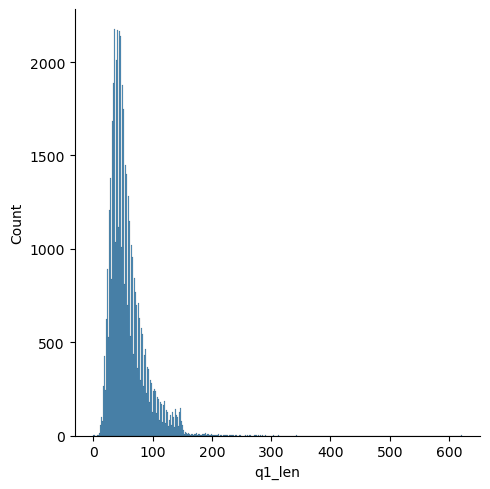

In [ ]:
# distribution of length of question_1

sns.displot(new_df['q1_len'])
print('Minimul length of question is ', new_df['q1_len'].min())
print('Maximum length of question is ', new_df['q1_len'].max())
print('Average length of question is ', round(new_df['q1_len'].mean(), 2))

Minimul length of question is  2
Maximum length of question is  1162
Average length of question is  57 2


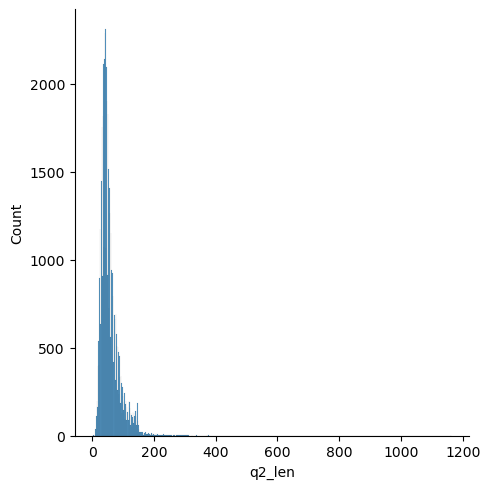

In [ ]:
# distribution of length of question_2

sns.displot(new_df['q2_len'])
print('Minimul length of question is ', new_df['q2_len'].min())
print('Maximum length of question is ', new_df['q2_len'].max())
print('Average length of question is ', round(new_df['q2_len'].mean()), 2)

Minimul words in question_1 is  1
Maximum words in question_1 is  147
Average words in question_1 is  11.22


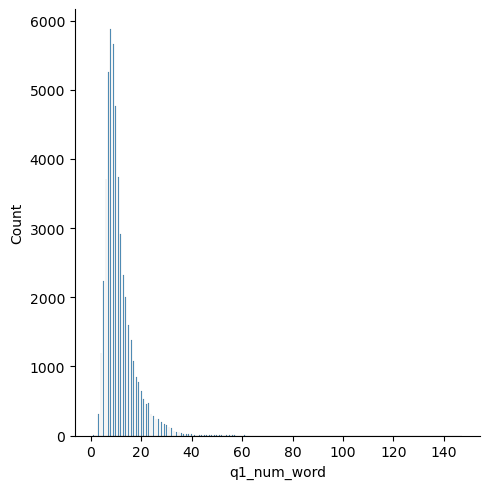

In [ ]:
# distribution of number of number of words in question_1

sns.displot(new_df['q1_num_word'])
print('Minimul words in question_1 is ', new_df['q1_num_word'].min())
print('Maximum words in question_1 is ', new_df['q1_num_word'].max())
print('Average words in question_1 is ', round(new_df['q1_num_word'].mean(), 2))

Minimul words in question_2 is  1
Maximum words in question_2 is  270
Average words in question_2 is  11.44


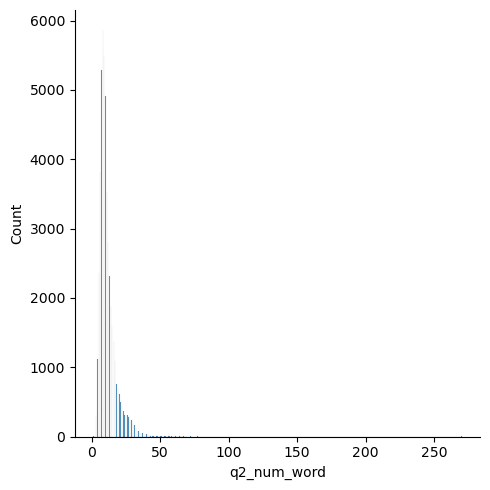

In [ ]:
# distribution of number of words in quesion_2

sns.displot(new_df['q2_num_word'])
print('Minimul words in question_2 is ', new_df['q2_num_word'].min())
print('Maximum words in question_2 is ', new_df['q2_num_word'].max())
print('Average words in question_2 is ', round(new_df['q2_num_word'].mean(), 2))

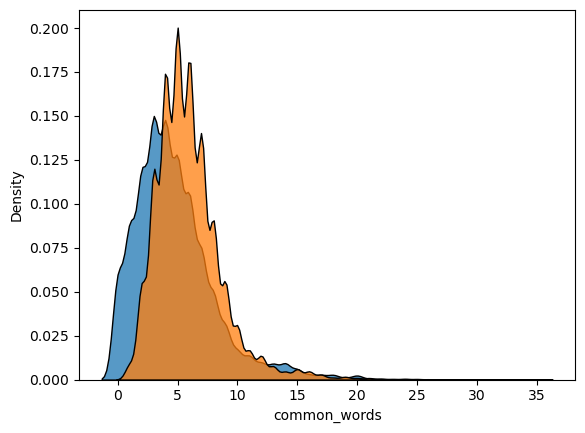

In [ ]:
# kde plot of common words 

sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['common_words'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['common_words'], legend=True, multiple='stack')
plt.show()

In [ ]:
# observations

# in above plot we can see that as number of common words increases, probability for duplicate question pair increases 

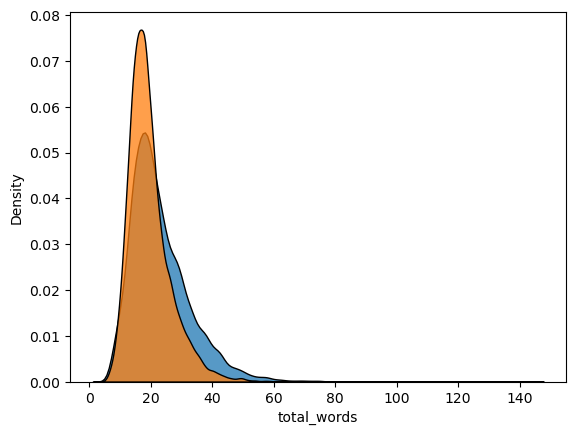

In [ ]:
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['total_words'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['total_words'], legend=True, multiple='stack')
plt.show()

In [ ]:
# observations

# as total words increases probability for question pair is not duplicate increases

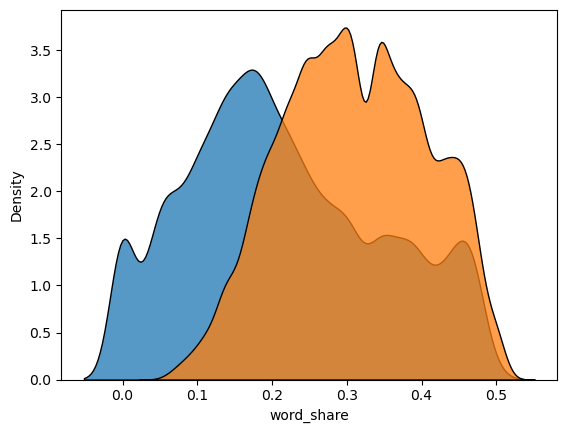

In [ ]:
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['word_share'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['word_share'], legend=True, multiple='stack')
plt.show()

In [ ]:
# observations

# as word share increases, probability of duplicate question pair increases

In [ ]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_word', 'q2_num_word', 'common_words',
       'total_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'mean_length',
       'abs_length_diff', 'longest_substring_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

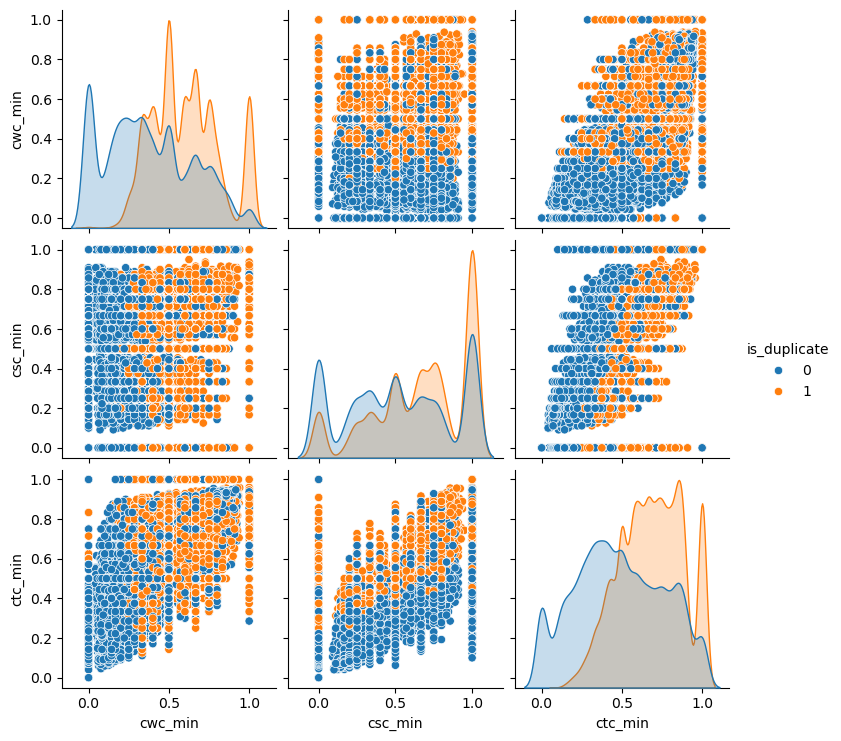

In [ ]:
sns.pairplot(new_df[['cwc_min', 'csc_min', 'ctc_min', 'is_duplicate']], hue='is_duplicate')

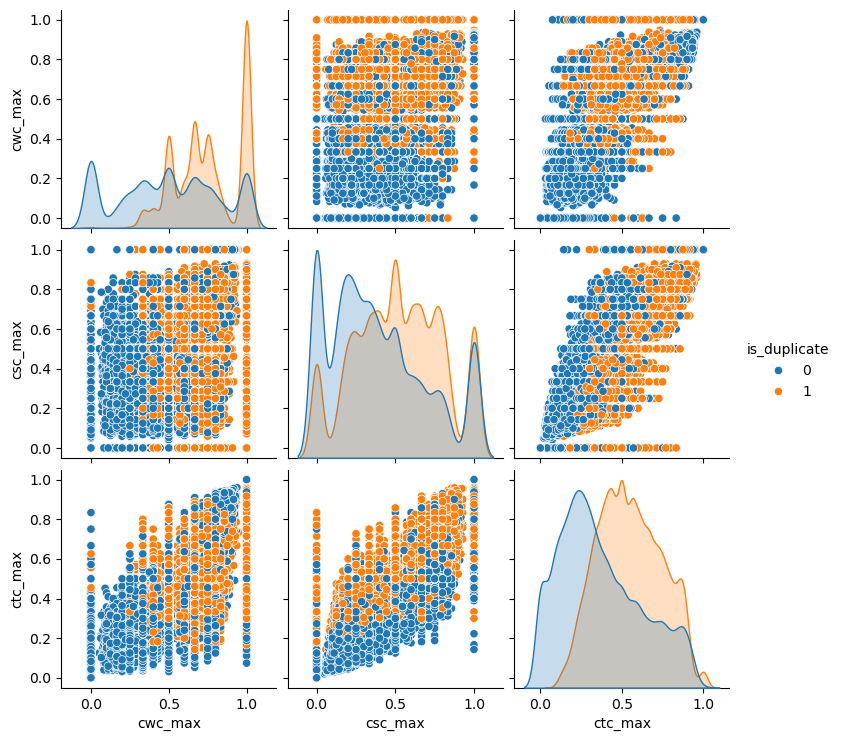

In [ ]:
sns.pairplot(new_df[['cwc_max', 'csc_max', 'ctc_max', 'is_duplicate']], hue='is_duplicate')

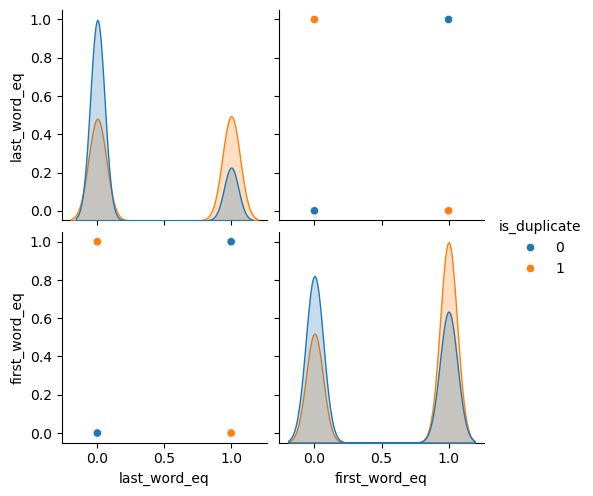

In [ ]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']], hue='is_duplicate')

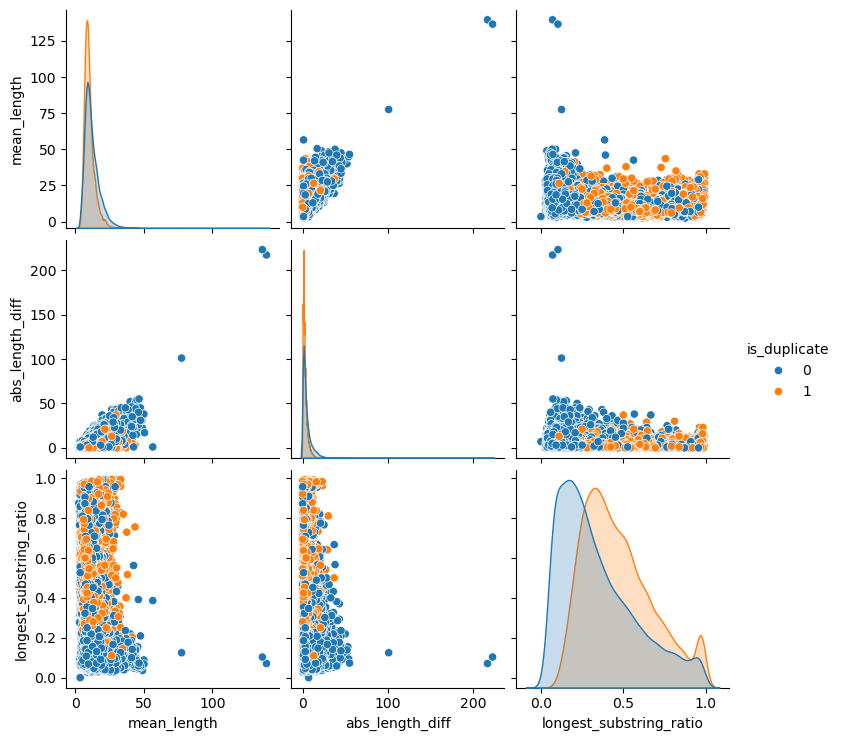

In [ ]:
sns.pairplot(new_df[['mean_length','abs_length_diff', 'longest_substring_ratio', 'is_duplicate']], hue='is_duplicate')

In [ ]:
# from above plots we can see that length features are not that much helpful

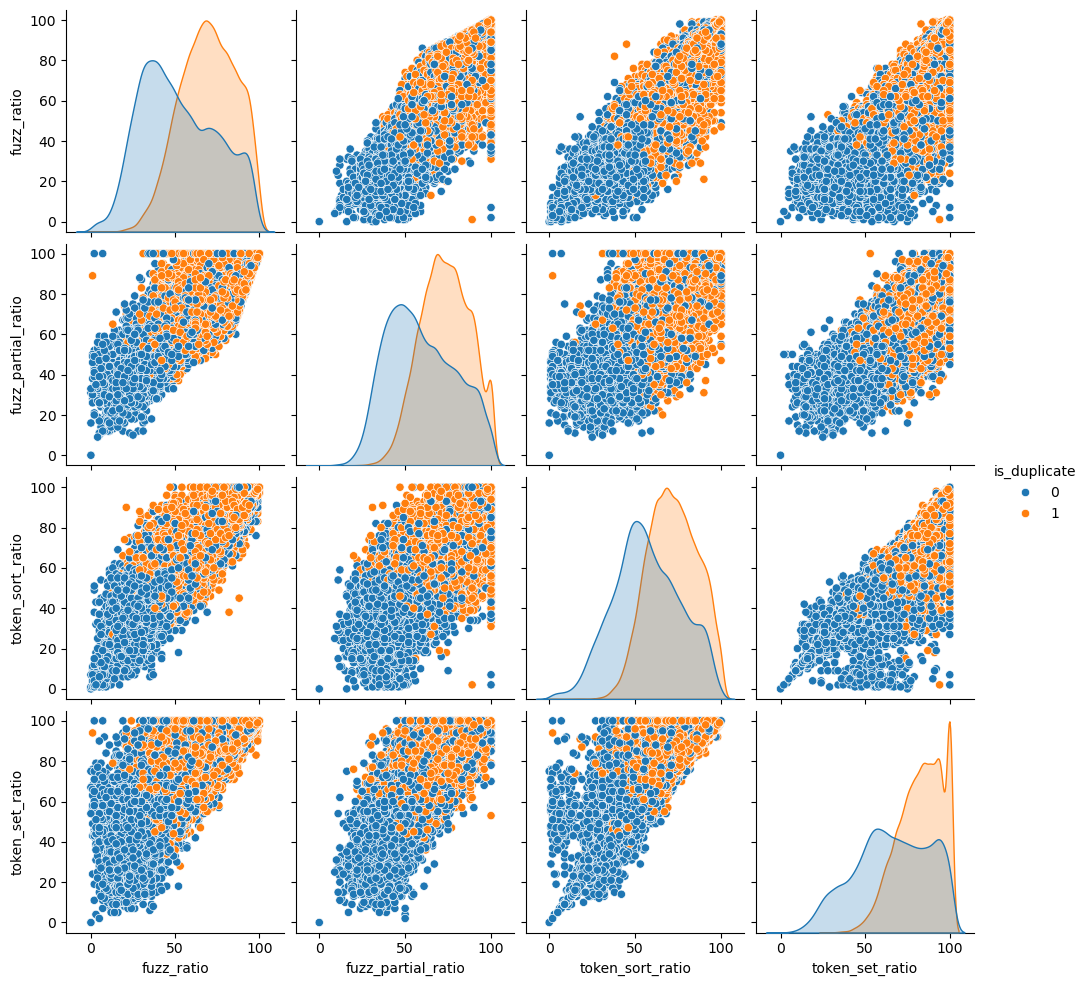

In [ ]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate')

## Creating Bag Of Words

In [31]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

questions = list(new_df['question1']) + list(new_df["question2"])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)

In [32]:
temp1 = pd.DataFrame(q1_arr, index=new_df.index)
temp2 = pd.DataFrame(q2_arr, index=new_df.index)

temp_df = pd.concat([temp1, temp2], axis=1)

temp_df.shape

(30000, 6000)

In [33]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_word', 'q2_num_word', 'common_words',
       'total_words', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

In [34]:
new_df.drop(columns = ['id', 'qid1', 'qid2', 'question1', 'question2'], inplace=True)

In [35]:
# main dataframe which is to be given to model

main_df = pd.concat([new_df, temp_df], axis=1)

In [36]:
main_df.head()

,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0,43,106,7,20,2,24,0.09,0.111110,0.166664,...,0,0,0,0,0,0,0,0,0,0
1,0,47,54,7,11,1,18,0.06,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,23,94,5,18,4,21,0.19,0.199998,0.999950,...,0,0,0,0,0,0,0,0,0,0
3,1,58,42,11,10,7,21,0.34,0.428565,0.499992,...,0,0,1,0,0,0,0,0,0,0
4,0,22,19,7,4,3,10,0.30,0.499975,0.999900,...,0,0,0,0,0,0,0,0,0,0


In [37]:
main_df.shape

(30000, 6020)

In [38]:
# test_df = main_df.iloc[40000:50000+1, :]
# main_df = main_df.iloc[:40000, :]

In [39]:
# # applying emsemble learning to handle imbalance dataset

# temp_df_1 = main_df[main_df['is_duplicate'] == 0].iloc[0:main_df[main_df['is_duplicate'] == 1].shape[0], :]
# temp_df_2 = main_df[main_df['is_duplicate'] == 1] 

# main_df_1 = pd.concat([temp_df_1, temp_df_2], axis=0).sample(frac=1).reset_index(drop=True)

# temp_df_3 = main_df[main_df['is_duplicate'] == 0].iloc[main_df[main_df['is_duplicate'] == 1].shape[0]: , :]
# temp_df_4 = main_df[main_df['is_duplicate'] == 1] 

# main_df_2 = pd.concat([temp_df_3, temp_df_4], axis=0).sample(frac=1).reset_index(drop=True)

# temp_df_5 = main_df[main_df['is_duplicate'] == 0].sample(main_df[main_df['is_duplicate'] == 1].shape[0])
# temp_df_6 = main_df[main_df['is_duplicate'] == 1]

# main_df_3 = pd.concat([temp_df_5, temp_df_6], axis=0).sample(frac=1).reset_index(drop=True)


In [40]:
# X_test = test_df.drop(columns=['is_duplicate']).values
# y_test = test_df['is_duplicate'].values

## Model Building 

In [41]:
# seperating dataset into X and y

X = main_df.drop(columns=['is_duplicate']).values
y = main_df['is_duplicate'].values

# X_2 = main_df_2.drop(columns=['is_duplicate']).values
# y_2 = main_df_2['is_duplicate'].values

# X_3 = main_df_3.drop(columns=['is_duplicate']).values
# y_3 = main_df_3['is_duplicate'].values

In [42]:
# splitting dataset for training and testing 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)



In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 12)

X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

In [49]:
# random forest classifier model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

rfc = RandomForestClassifier()
 
rfc.fit(X_train_resample, y_train_resample)
 
rfc_y_pred = rfc.predict(X_test)

print('Accuracy of Random Forest Classifier is ', accuracy_score(y_test, rfc_y_pred))

print(confusion_matrix(y_test, rfc_y_pred))

report = classification_report(y_test, rfc_y_pred)

print(report)

with open('rfc.txt', 'w') as f:
    f.write(report)



Accuracy of Random Forest Classifier is  0.7834666666666666
[[3999  684]
 [ 940 1877]]


In [50]:
# xgbclassifier model

from xgboost import XGBClassifier

xgb = XGBClassifier()
 
xgb.fit(X_train_resample, y_train_resample)
 
xgb_y_pred = xgb.predict(X_test)


print('Accuracy for xgboost is ', accuracy_score(y_test, xgb_y_pred))

print(confusion_matrix(y_test, xgb_y_pred))

report = classification_report(y_test, xgb_y_pred)

print(report)

with open('xgb.txt', 'w') as f:
    f.write(report)


Accuracy for xgboost is  0.7832
[[3908  775]
 [ 851 1966]]


In [65]:
# Both models random forest classifier and xgboost performing nearly same, 
# since I have to reduce false negative i.e. typeI error I will go with Random Forest Classifier

In [66]:
# naive bayes classifier

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

gnb_y_pred = gnb.predict(X_test)
print('Accuracy of GaussianNB is ', accuracy_score(gnb_y_pred, y_test))
confusion_matrix(gnb_y_pred, y_test)


Accuracy of GaussianNB is  0.6552


array([[3410, 1494],
       [2816, 4780]], dtype=int64)

In [67]:
# from sklearn.svm import SVC

# svc = SVC()
# svc.fit(X_train, y_train)

# svc_y_pred = svc.predict(X_test)
# print('Accuracy of SVC is ', accuracy_score(svc_y_pred, y_test))
# confusion_matrix(svc_y_pred, y_test)


In [68]:
import pickle

with open ('model.pkl', 'wb') as file1:
    pickle.dump(xgb, file1)

with open('cv.pkl', 'wb') as file2:
    pickle.dump(cv, file2)
      